<a href="https://colab.research.google.com/github/hinton024/Assignment-2-Social-media-and-network-analytics/blob/main/Reddit_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download necessary libraries

In [5]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.3 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=be3899576d1d680ce90df142ff95ce5f787bbced659b40e5088f03534e981fcb
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


### Importing the Necessary Libraries

In [6]:
import pandas as pd
import re
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import nltk
from langdetect import detect, LangDetectException
import contractions
from collections import Counter

### 1. Data Preprocessing
#### Loading the Data

In [7]:
# List of NLTK data packages to download
nltk_packages = ['punkt', 'wordnet', 'stopwords']

# Download each package
for package in nltk_packages:
    nltk.download(package)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
with open('DB_reddit.json', 'r', encoding='utf-8') as file:
    reddit = json.load(file)

# Converting the data into a DataFrame
df = pd.DataFrame(reddit)
df.head()

,title,score,date,url,num_comments,comments
0,Not under David Beckhams watch,65534,2023-10-06 17:16:05,https://v.redd.it/0mmzjpgdyisb1,2042,"[Please report rule breaking posts, such as:\n..."
1,David Beckham is not letting this go...,29482,2024-01-02 14:44:45,https://i.redd.it/dowdawvo7y9c1.jpeg,982,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
2,David and Victoria Beckham finally addressing ...,800,2023-10-05 20:46:41,https://v.redd.it/ahnysog1vcsb1,261,[I think if they hadn’t brought this up in a d...
3,Victoria Beckham shares photo of husband David...,2687,2023-12-16 10:45:59,https://i.redd.it/nd35a08lpj6c1.jpeg,298,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
4,Micah Richards on David Beckham,5650,2024-09-19 18:27:36,https://v.redd.it/7o6n7df28qpd1,256,[**Mirrors / Alternative Angles**\n \n\n*I am...


#### Check for Missing Values

In [9]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()

# Display missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
title           0
score           0
date            0
url             0
num_comments    0
comments        0
dtype: int64


#### Check for Duplicate Values

In [10]:
duplicates = df.duplicated(subset=['url']).sum()
print(f"Number of duplicate rows: {duplicates}")
df.drop_duplicates(subset=['url'], inplace=True)

Number of duplicate rows: 0


#### Advance Preprocessing

In [11]:
# Regular expression pattern for detecting URLs
url_pattern = r'http\S+|www\S+|https\S+'

# Function to check for URLs in text
def contains_url(text):
    return bool(re.search(url_pattern, text))

# Check for URLs in the 'title' column
df['Title_Contains_URL'] = df['title'].apply(contains_url)

# Check for URLs in the 'comments' column (handling multiple comments in each row)
df['Comments_Contain_URL'] = df['comments'].apply(lambda comments: any(contains_url(comment) for comment in comments))

# Display rows where URLs are found in either title or comments
urls_in_data = df[(df['Title_Contains_URL']) | (df['Comments_Contain_URL'])]

# Display the results
print(f"Total rows with URLs in title: {df['Title_Contains_URL'].sum()}")
print(f"Total rows with URLs in comments: {df['Comments_Contain_URL'].sum()}")

# Optionally, display the rows that contain URLs
if not urls_in_data.empty:
    print("\nRows containing URLs:")
    print(urls_in_data[['title', 'comments']].head())
else:
    print("\nNo URLs found in the dataset.")

Total rows with URLs in title: 0
Total rows with URLs in comments: 81

Rows containing URLs:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   

                                            comments  
0  [Please report rule breaking posts, such as:\n...  
1  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
2  [I think if they hadn’t brought this up in a d...  
3  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
4  [**Mirrors / Alternative Angles**\n  \n\n*I am...  


In [12]:
# Function to clean text (already removing URLs)
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9'\s]", '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Reapply the cleaning function to comments with URLs
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [clean_text(comment) for comment in comments])

# Verify the removal of URLs by checking the updated comments
urls_in_comments_after_removal = df['Cleaned_Comments'].apply(lambda comments: any(re.search(url_pattern, comment) for comment in comments)).sum()
print(f"Total rows with URLs in comments after removal: {urls_in_comments_after_removal}")


# Function to detect if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

Total rows with URLs in comments after removal: 0


In [13]:
# Cleaning and preprocess titles
df['Cleaned_Title'] = df['title'].apply(lambda x: expand_contractions(clean_text(str(x))) if is_english(str(x)) else '')

# Preprocessing each comment within the list
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [expand_contractions(clean_text(comment)) for comment in comments if is_english(comment)])

#### Stopwords Removal

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_tokens(tokens):
    # Remove stopwords and lemmatize
    tokens = [word for word in tokens if word not in stop_words]
    # If no tokens are left after stopword removal, return the original tokens
    if not tokens:
        return tokens
    return [lemmatizer.lemmatize(word) for word in tokens]

#### Tokenization and Lemmatization

In [15]:
# Tokenize and lemmatize the cleaned text
df['Title_Tokens'] = df['Cleaned_Title'].apply(lambda x: process_tokens(word_tokenize(x)))
df['Comments_Tokens'] = df['Cleaned_Comments'].apply(lambda comments: [process_tokens(word_tokenize(comment)) for comment in comments])

In [16]:
# Display the processed data
processed_columns = ['title', 'Cleaned_Title', 'Title_Tokens', 'comments', 'Cleaned_Comments', 'Comments_Tokens']
print("\nProcessed Data:")
print(df[processed_columns].head(10))


Processed Data:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   
5                                Young David Beckham   
6                         Thoughts on David Beckham?   
7  david beckham: then vs now – is it just me or ...   
8                          David Beckham is autistic   
9  David and Victoria Beckham recreate their wedd...   

                                       Cleaned_Title  \
0                                                      
1               david beckham is not letting this go   
2  david and victoria beckham finally addressing ...   
3  victoria beckham shares photo of husband david...   
4                    micah richards on david beckham   
5                             

#### Term Frequency

In [17]:
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

def process_text(text, lemmatizer, stopwords_set):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_set]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

term_freq_counter = Counter()

# Processing each row in the DataFrame and updating term frequency counts
for _, row in df.iterrows():
    tokens_title = process_text(row['Cleaned_Title'], lemmatizer, stopwords_set)
    tokens_comments = [word for comment in row['Cleaned_Comments'] for word in process_text(comment, lemmatizer, stopwords_set)]

    # Updating term frequency counts
    term_freq_counter.update(tokens_title)
    term_freq_counter.update(tokens_comments)

# Displaying the most common terms
freq_num = 50
print(f"Top {freq_num} most common terms:")
for term, count in term_freq_counter.most_common(freq_num):
    print(f"{term}: {count}")

Top 50 most common terms:
like: 2633
would: 1823
people: 1740
think: 1396
one: 1358
know: 1189
look: 1128
class: 1110
get: 1087
beckham: 1076
time: 1000
really: 913
even: 910
david: 852
good: 841
also: 823
make: 805
year: 798
thing: 780
much: 771
love: 722
still: 703
way: 697
's: 678
never: 670
could: 667
see: 620
working: 618
well: 613
going: 605
money: 598
say: 579
always: 564
lol: 561
got: 559
go: 550
lot: 543
want: 530
right: 517
victoria: 511
work: 510
someone: 506
mean: 504
u: 503
woman: 467
said: 459
man: 458
back: 454
made: 448
though: 444


# WordCloud of Sentiment Heavy Words and Entities

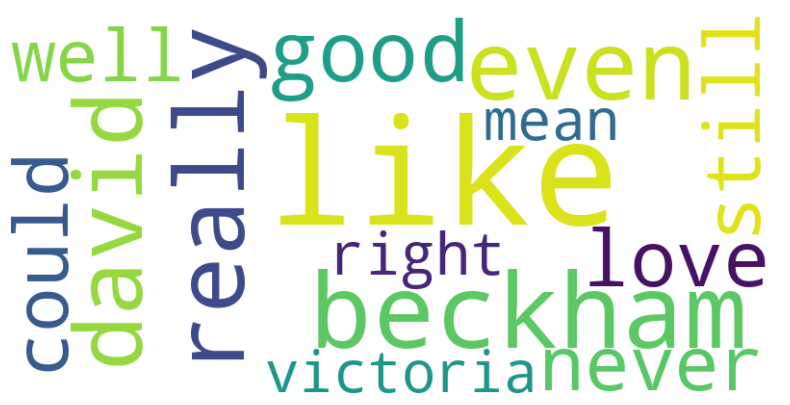

In [18]:
# Visualizing the sentiment heavy words and entities by WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Dictionary with sentiment heavy words and entities and their frequencies as values
words_freq = {
    "like": 2627,
    "beckham": 1077,
    "really": 912,
    "even": 911,
    "good": 844,
    "david": 848,
    "love": 720,
    "still": 702,
    "never": 671,
    "could": 669,
    "well": 614,
    "right": 517,
    "victoria": 512,
    "mean": 504
}


# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)

# Plotting the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hiding axes
plt.show()


# Bar Chart of Sentiment Heavy Words and Entities with their frequencies

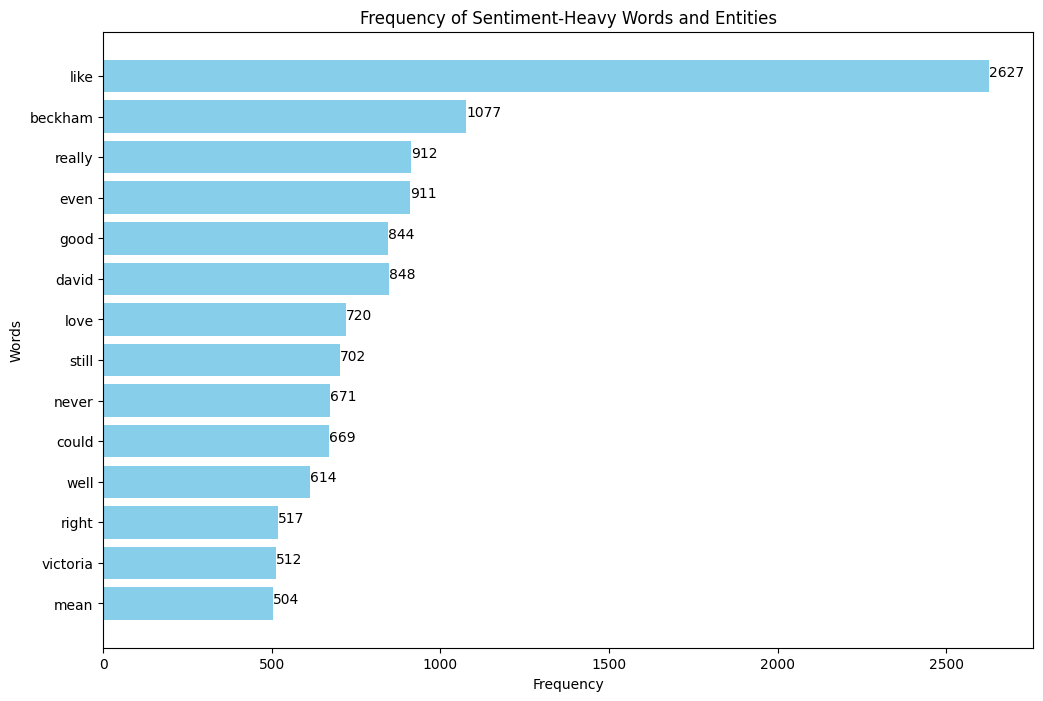

In [19]:
# Visualizing the sentiment heavy words and entities and their frequencies as values

# List of words and their frequencies
words = [
    'like', 'beckham', 'really', 'even', 'good', 'david', 'love',
    'still', 'never', 'could', 'well', 'right', 'victoria', 'mean'
]

frequencies = [
    2627, 1077, 912, 911, 844, 848, 720,
    702, 671, 669, 614, 517, 512, 504
]


# Plotting the bar chart
plt.figure(figsize=(12,8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency of Sentiment-Heavy Words and Entities')
plt.gca().invert_yaxis()  # Inverting y axis to have the most frequent word on top

# Adding frequencies next to the bars  # Adding frequencies next to the bar
for index, value in enumerate(frequencies):
    plt.text(value, index, str(value))
plt.show()


# Tfidf Vectorization

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for Pre-processing text by removing numbers
def preprocess_text(text):
    return re.sub(r'\d+', '', text)

# loading data from json file
with open('DB_reddit.json', 'r', encoding='utf-8') as f:
    posts_data = json.load(f)

    comments = []
    for post in posts_data:
        for comment in post['comments']:
            preprocessed_comment = preprocess_text(comment)  # Preprocessing the comments
            comments.append(preprocessed_comment)  # Storing preprocessed comments

# Converting the comments into a dataframe
df = pd.DataFrame(comments, columns=['Cleaned_Comments'])

# Checking the dataframe
print("DataFrame preview (first 5 rows):")
print(df.head())

# Adjusting the token pattern to exclude purely numerical tokens and refining the ngram range
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',  # Excludes purely numeric tokens and requires at least three characters
    ngram_range=(1,2),  #unigram and bi-gram
    min_df=10,  # Increase min_df to reduce features that appear rarely
    max_df=0.5 # Lower max_df to exclude terms that are too common

)

# Fitting and transforming the comments into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Comments']).toarray()

# Converting to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

DataFrame preview (first 5 rows):
                                    Cleaned_Comments
0  Please report rule breaking posts, such as:\n\...
1                         David ain't fuckin' around
2  David Beckham actually grew up working class s...
3           Well, she wasn’t Poor Spice for a reason
4  David Beckham is pissed because he is actually...
   ability  able  absolute  absolutely     abuse  accent   account  act  \
0      0.0   0.0       0.0         0.0  0.312261     0.0  0.152936  0.0   
1      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
2      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
3      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
4      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   

   acting   action  ...  year old  years  years ago  yep  yes  young  younger  \
0     0.0  0.13697  ...       0.0    0.0        0.0  0.0  0.0    0.0      0.0   
1     0.0  0.00000  ...       0.0  

# Vader Sentiment Analysis

In [21]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initializing VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis with error handling
def analyze_sentiment(text):
    if text:  # Checking if text is not empty or None
        try:
            sentiment = analyzer.polarity_scores(text)
            return sentiment['compound']  # Compund score represents overall sentiment
        except Exception as e:
            print(f"Error analyzing sentiment: {e}")
            return None  # Return None if there's an error
    else:
        return None  # Return None for empty or None text

# Applying sentiment analysis
df['sentiment_score'] = df['Cleaned_Comments'].apply(analyze_sentiment)

# Categorize sentiment based on the score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Printing results
print("DataFrame with sentiment scores and categories (first 5 rows):")
print(df[['Cleaned_Comments', 'sentiment_score', 'sentiment_category']].head())

DataFrame with sentiment scores and categories (first 5 rows):
                                    Cleaned_Comments  sentiment_score  \
0  Please report rule breaking posts, such as:\n\...          -0.9505   
1                         David ain't fuckin' around           0.0000   
2  David Beckham actually grew up working class s...           0.0000   
3           Well, she wasn’t Poor Spice for a reason          -0.2500   
4  David Beckham is pissed because he is actually...          -0.6369   

  sentiment_category  
0           negative  
1            neutral  
2            neutral  
3           negative  
4           negative  


# Visualizing sentiment score distribution by histogram and density plot

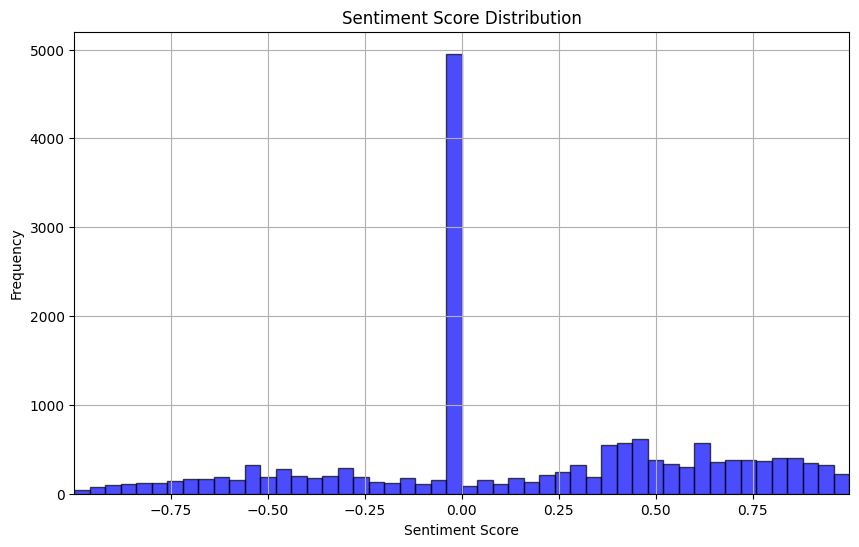

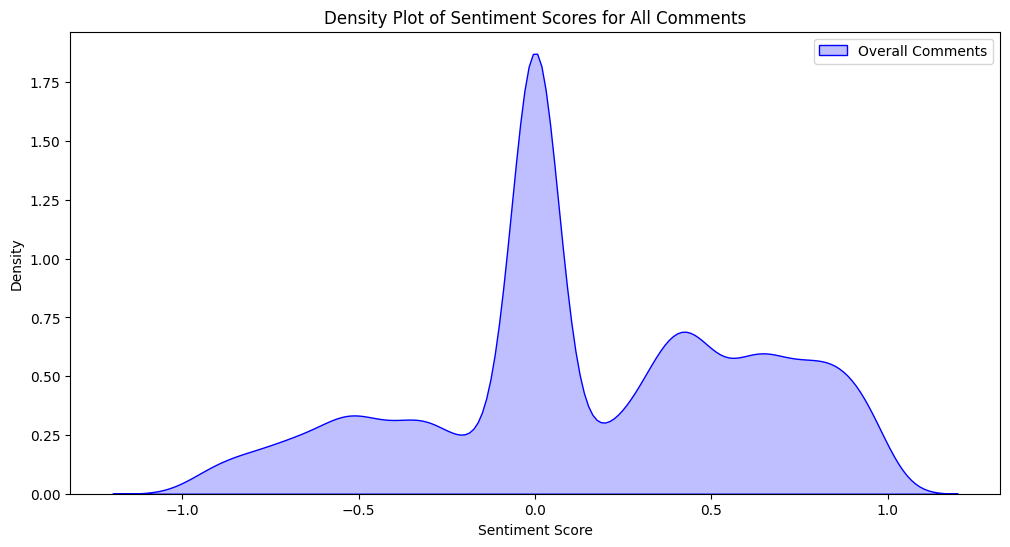

In [22]:
#Visualizing sentiment score distribution by histogram and density plot

num_bins = 50  # Number of bins

# Plotting sentiment score distribution
plt.figure(figsize=(10,6))
plt.hist(df['sentiment_score'], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.grid(True)   # For better readability

# Setting plot titles and labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')

# Setting x and y limits
plt.xlim(df['sentiment_score'].min(), df['sentiment_score'].max())
plt.ylim(0, plt.ylim()[1])  # Ensuring y axis starts from 0 and is correclty scaled

plt.show()


# Plotting density of sentiment scores for all comments
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(df['sentiment_score'], fill=True, color='blue', label='Overall Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores for All Comments')
plt.legend()
plt.show()

# Word Cloud for overall comments

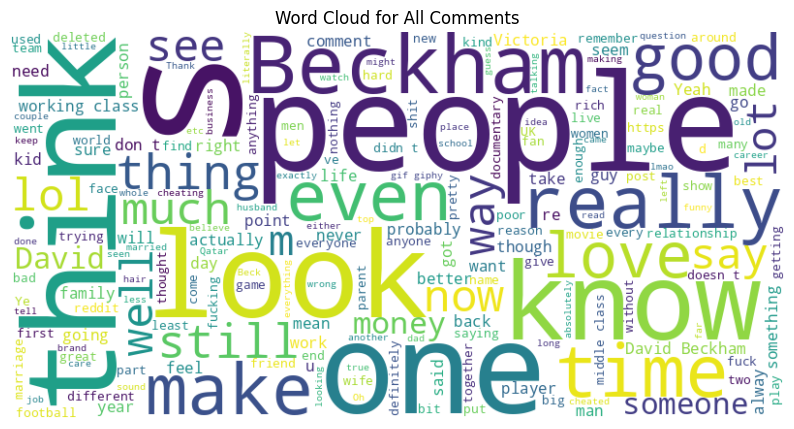

In [23]:
# Word Cloud for overall comments

from wordcloud import WordCloud, STOPWORDS
all_comments = ' '.join(df['Cleaned_Comments'])

# Generating word cloud with custom settings
wordcloud = WordCloud(
    width=800, height=400, background_color='white',
    stopwords=set(STOPWORDS), max_words=200, colormap='viridis'
).generate(all_comments)

# Displaying the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels and ticks
plt.title('Word Cloud for All Comments')
plt.show()


## Topic Modelling

### Plotting coherence term plot to determine optimal number of topics

In [24]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import numpy as np
# Extracting 'Cleaned_Comments' from the DataFrame
lPosts = df['Cleaned_Comments'].tolist()
data = [post.split() for post in lPosts]

# Create Dictionary and Corpus (this part remains the same)
id2word = corpora.Dictionary(data)
texts = data
corpus = [id2word.doc2bow(text) for text in texts]

# def compute_coherence_for_model(params):
#     """Compute coherence for a single model"""
#     num_topics, dictionary, corpus, texts = params
#     model = gensim.models.LdaModel(
#         corpus=corpus,
#         id2word=dictionary,
#         num_topics=num_topics,
#         random_state=100,
#         update_every=1,
#         chunksize=100,
#         passes=10,
#         alpha='auto',
#         per_word_topics=True
#     )
#     coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#     return coherence_model.get_coherence()

# def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
#     """Compute coherence values for multiple models in parallel"""
#     pool = Pool(processes=cpu_count())
#     coherence_values = pool.map(
#         compute_coherence_for_model,
#         [(num_topics, dictionary, corpus, texts) for num_topics in range(start, limit, step)]
#     )
#     pool.close()
#     pool.join()
#     return coherence_values

# # Set parameters
# start, limit, step = 2, 40, 6

# # Compute coherence values
# coherence_values = compute_coherence_values(id2word, corpus, texts, start, limit, step)

# # Plot results
# x = range(start, limit, step)
# plt.figure(figsize=(12, 6))
# plt.plot(x, coherence_values, 'bo-')
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.title("Topic Coherence Scores by Number of Topics")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Find optimal number of topics
# optimal_num_topics = x[np.argmax(coherence_values)]
# print(f'Optimal number of topics: {optimal_num_topics}')


In [32]:
topicNum = 20
wordNumToDisplay = 10
featureNum = 1500

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Performs counting via CountVectorizer and then apply the LDA model.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lPosts)
tfFeatureNames = tfVectorizer.get_feature_names_out()

ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualising topics

In [34]:
# Define the display_topics function
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        for i in topic.argsort()[:-num_top_words - 1:-1]:
            print(f"{feature_names[i]} ({topic[i]:.4f})")
        print()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Diplays discovered topics.

In [35]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
love (667.5628)
didn (449.7118)
mean (283.9818)
say (275.4768)
documentary (242.8299)
new (193.4165)
saw (169.0592)
tell (143.7980)
til (120.2712)
interesting (108.2590)

Topic 1:
got (528.8065)
said (463.1213)
years (438.7627)
best (335.9635)
year (246.1430)
didn (245.1424)
day (225.3571)
friends (216.1733)
let (203.2473)
oh (202.1903)

Topic 2:
way (290.9716)
long (279.3340)
makes (265.0357)
thing (197.9899)
play (195.9921)
lmao (176.2086)
end (176.1385)
true (174.3938)
club (146.3982)
playing (120.8963)

Topic 3:
time (712.5357)
guy (325.0335)
real (308.5799)
just (263.0542)
does (262.5225)
sure (204.9557)
trying (176.4028)
nice (154.9660)
think (147.8326)
dude (140.4319)

Topic 4:
https (461.2880)
com (322.8012)
www (257.8493)
reddit (257.1026)
team (249.5385)
football (166.3518)
left (164.6502)
funny (155.6542)
en (142.2568)
soccer (129.1320)

Topic 5:
victoria (442.4233)
wouldn (205.3959)
wife (186.6401)
ugly (168.3443)
happy (152.7096)
rolls (146.3987)
hope (144.1629)
k

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne') # Use lda_model for prepare
pyLDAvis.display(panel)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Network Analysis and Community Detection

In [64]:
import networkx as nx
from networkx.algorithms import community
from sklearn.metrics.pairwise import cosine_similarity
# Define a threshold for considering a document as related to a topic
threshold = 0.5
doc_topic_dist = ldaModel.transform(tf)
# Iterate over each topic
for topic_idx in range(ldaModel.n_components):
    # Extract documents related to the current topic
    related_docs_indices = np.where(doc_topic_dist[:, topic_idx] > threshold)[0]
    related_docs = [lPosts[i] for i in related_docs_indices]

    # Print the related documents
    print(f"Documents related to Topic {topic_idx}:\n")
    for idx, doc in enumerate(related_docs):
        print(f"Document {idx + 1}: {doc}\n")

    # Perform community analysis
    # Step 1: Vectorize the related documents using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(related_docs)

    # Step 2: Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)

    # Step 3: Create a graph from the cosine similarity matrix
    G = nx.Graph()
    for i in range(len(related_docs)):
        for j in range(i + 1, len(related_docs)):
            if cosine_sim_matrix[i, j] > 0.5:  # Example threshold, adjust as needed
                G.add_edge(i, j, weight=cosine_sim_matrix[i, j])

# Step 4: Detect communities using the Girvan-Newman method
    communities_generator = community.girvan_newman(G) # Call girvan_newman directly from the community module
    top_level_communities = next(communities_generator)
    sorted_communities = sorted(map(sorted, top_level_communities))

# Print the communities
    print(f"Communities for Topic {topic_idx}:\n")
    for idx, community_list in enumerate(sorted_communities): # Renamed 'community' to 'community_list' to avoid name conflict
        print(f"Community {idx + 1}:")
        for doc_idx in community_list:
            print(f"Document {doc_idx + 1}: {related_docs[doc_idx]}")
        print("="*80)  # Separator between communities

    # Export the graph to a GEXF file for Gephi
    nx.write_gexf(G, f"reddit_document_similarity_graph_topic_{topic_idx}.gexf")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.

Document 40: Before or after he cheated with Rebecca loos?

Document 41: Her performance at the Golden Jubilee was fantastic.

Document 42: Beccy Loose, the real posh spice.

Document 43: I was all about Posh Spice or Ginger Spice (and still am with the latter).

Document 44: Seems about right for Posh Spice xD

Document 45: Markie was cooler when he cosplays a black rapper.

Document 46: Posh spice trying to say she wasn’t POSH come on now…

Document 47: Posh Spice was RICH?!
Unbelievable!🤣

Document 48: Why was she called Posh Spice then??

Document 49: Calm down Posh Spice.

Document 50: I know. Her name was POSH SPICE.

Document 51: Lmao. Peasant Spice. Proletariat Spice! Wage Slave Spice! 💕

Document 52: She still called herself posh spice and answered to posh spice. Hello?

Document 53: Push Up Spice.

Document 54: Skeletal Spice.

Document 55: Incredible

Document 56: Congratulations, Posh!

Document 57: It wasn’t Spice…?

Docu

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


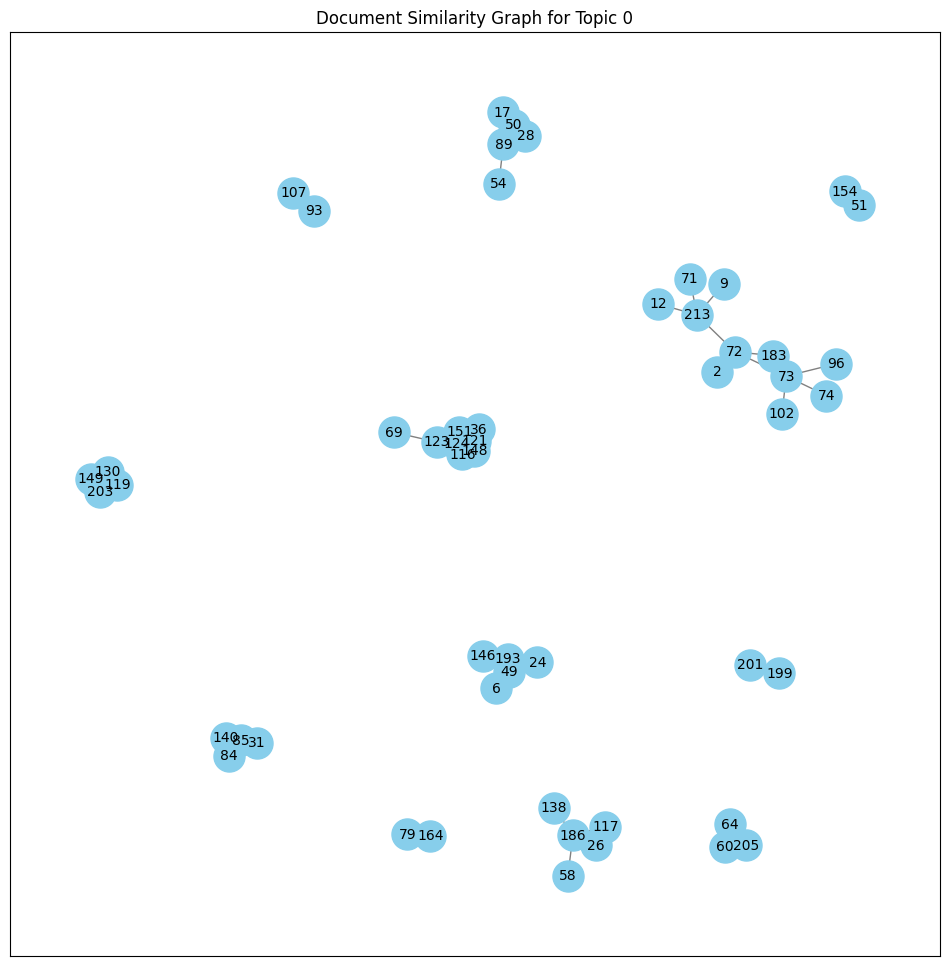

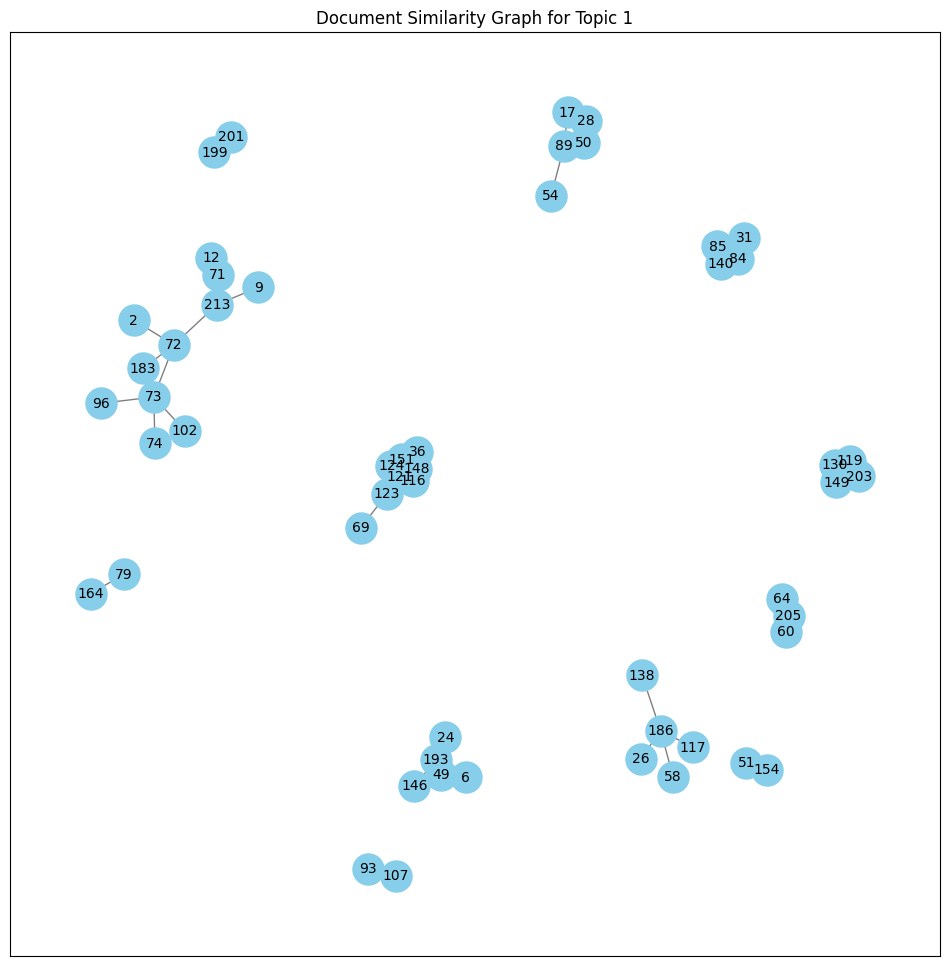

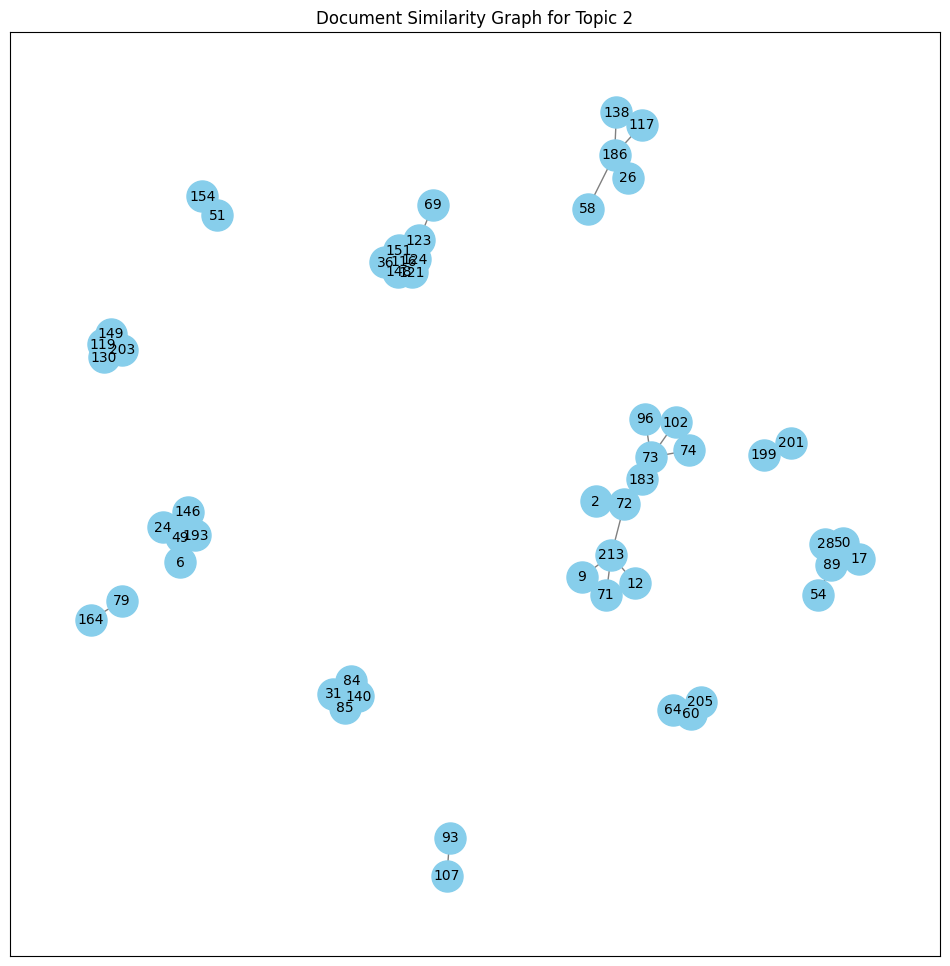

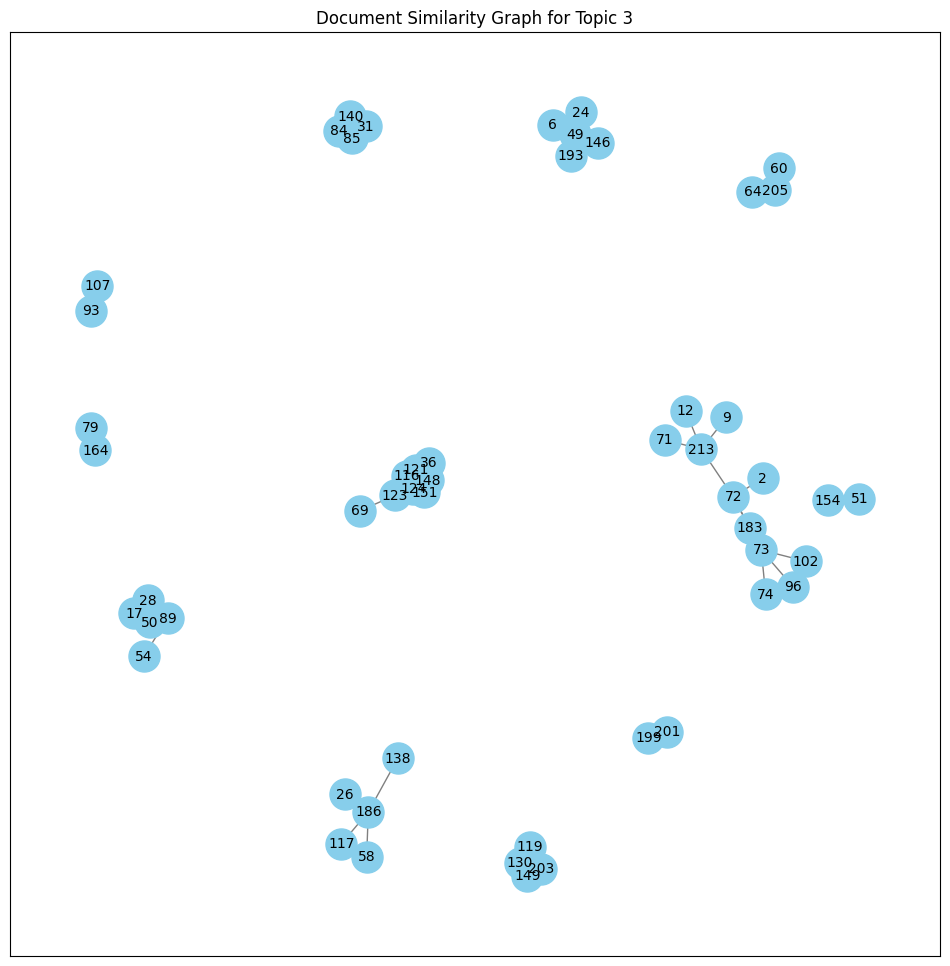

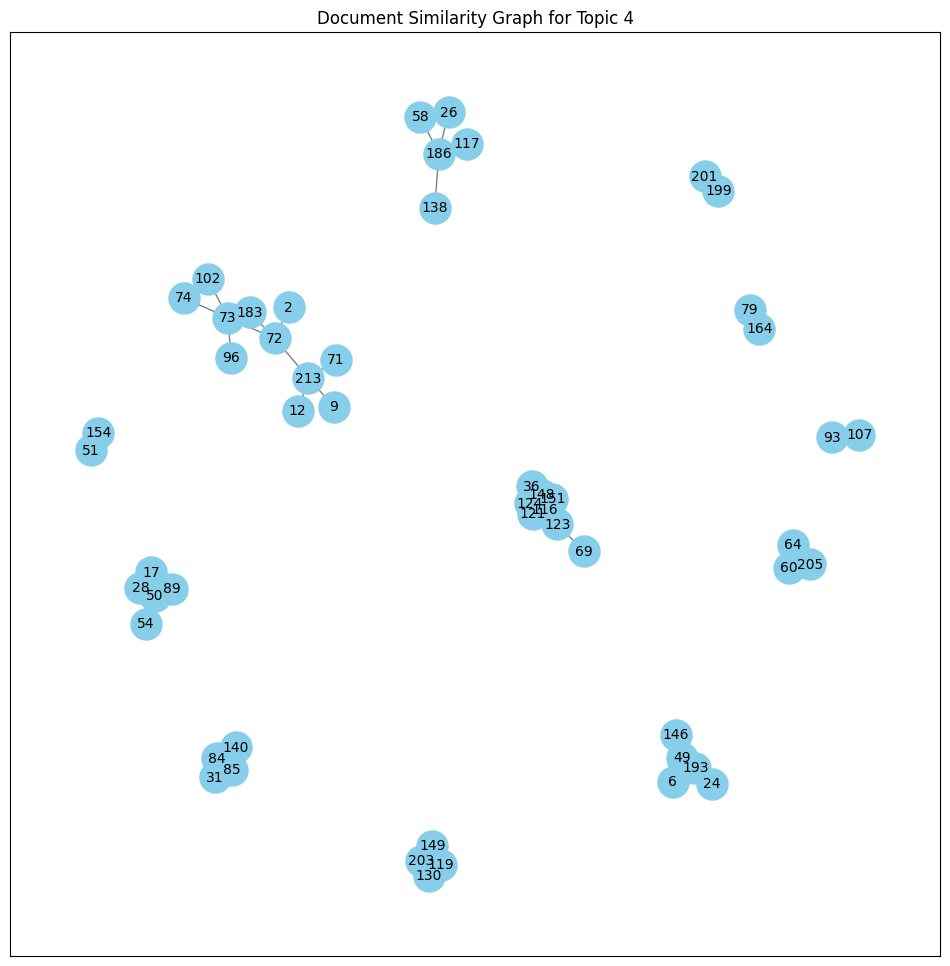

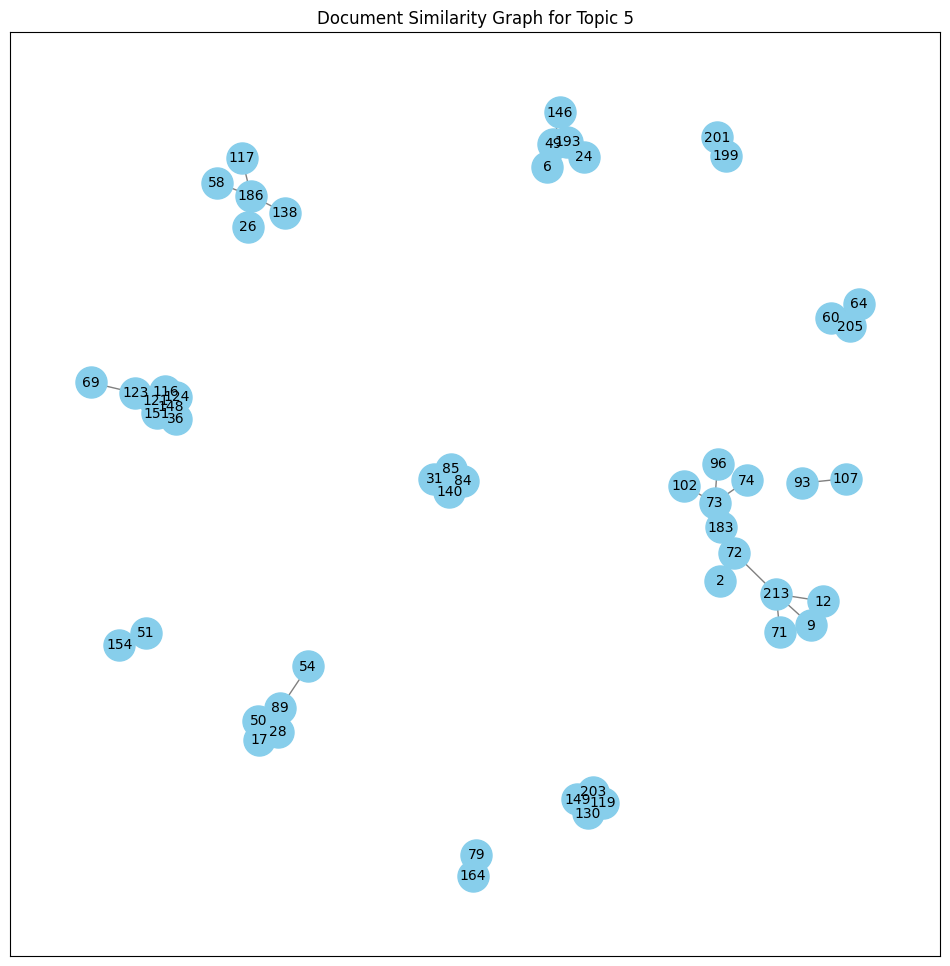

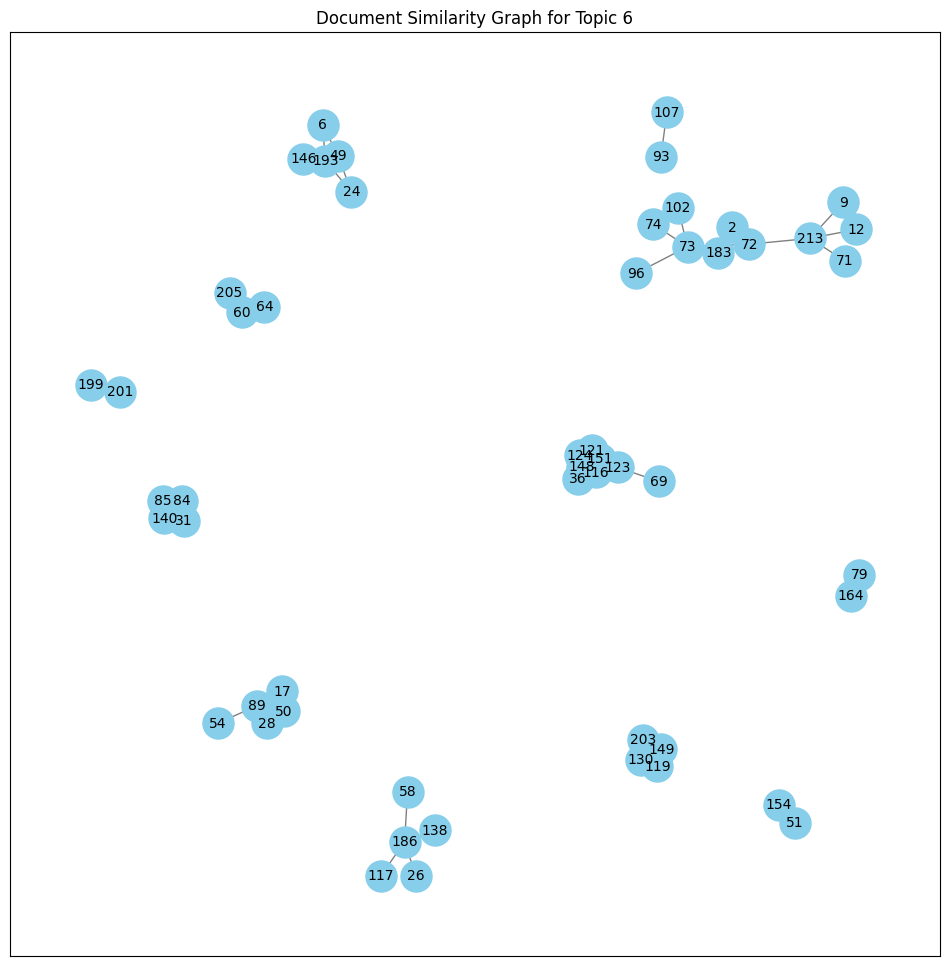

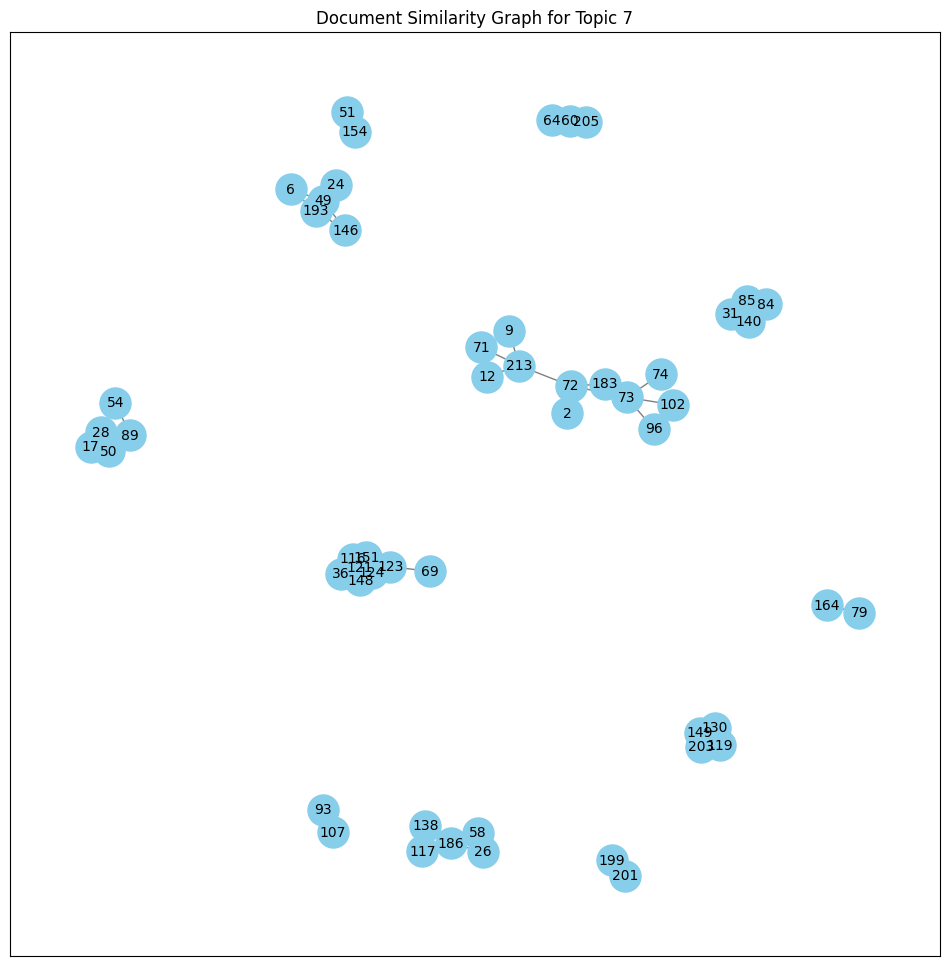

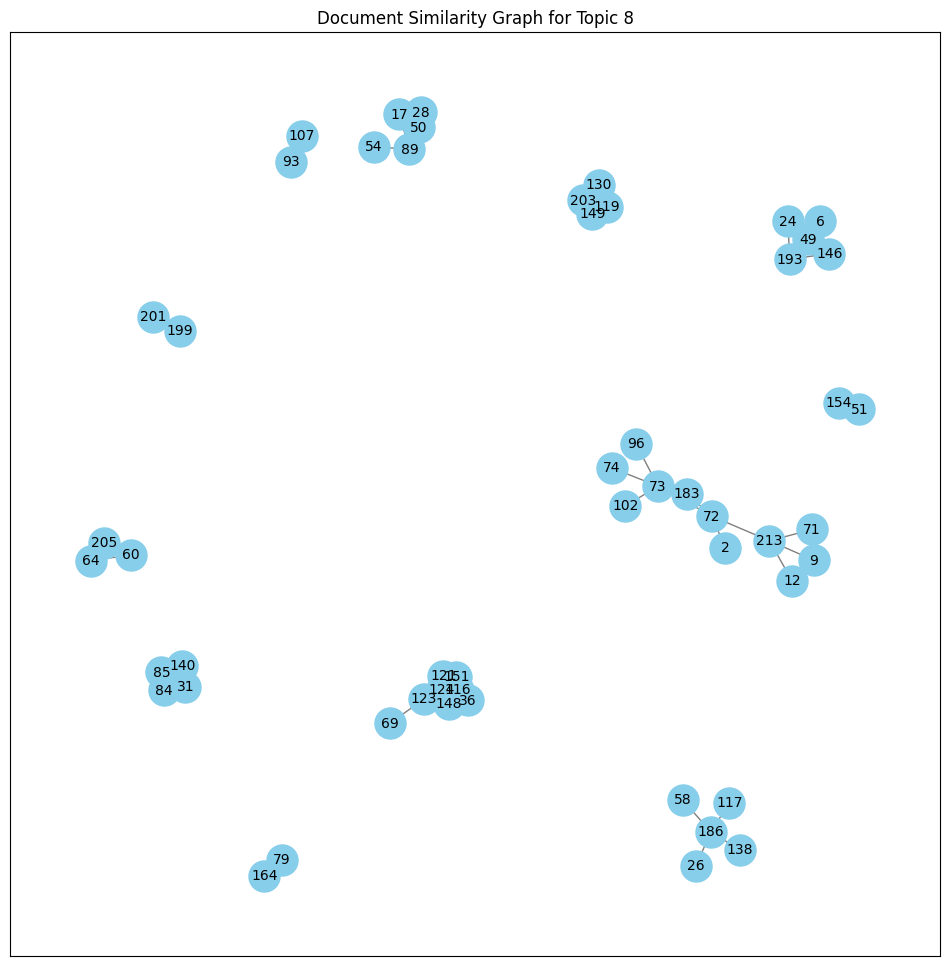

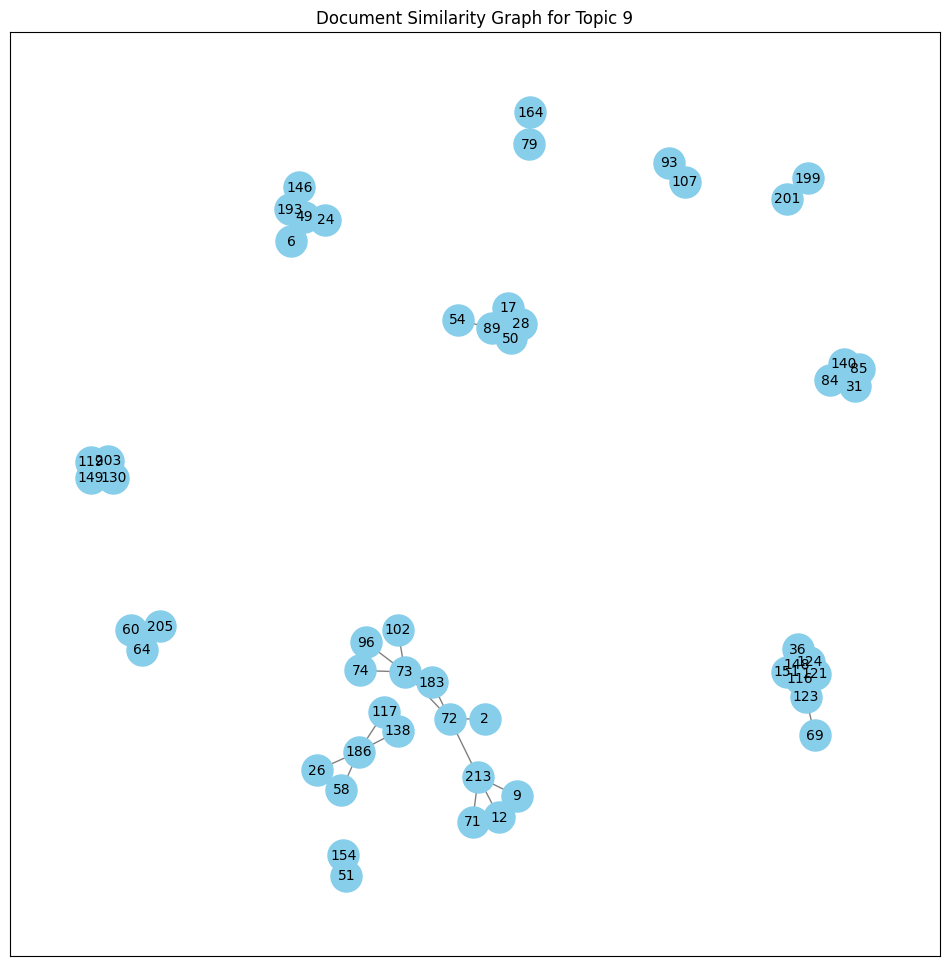

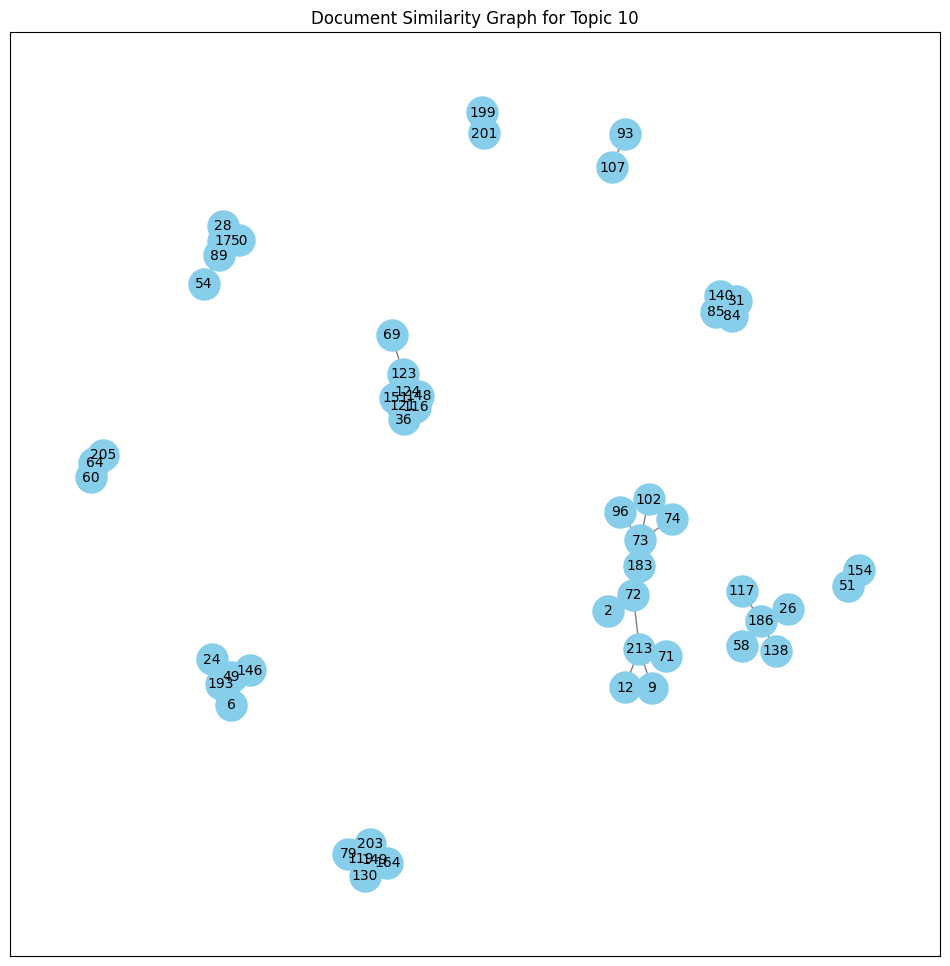

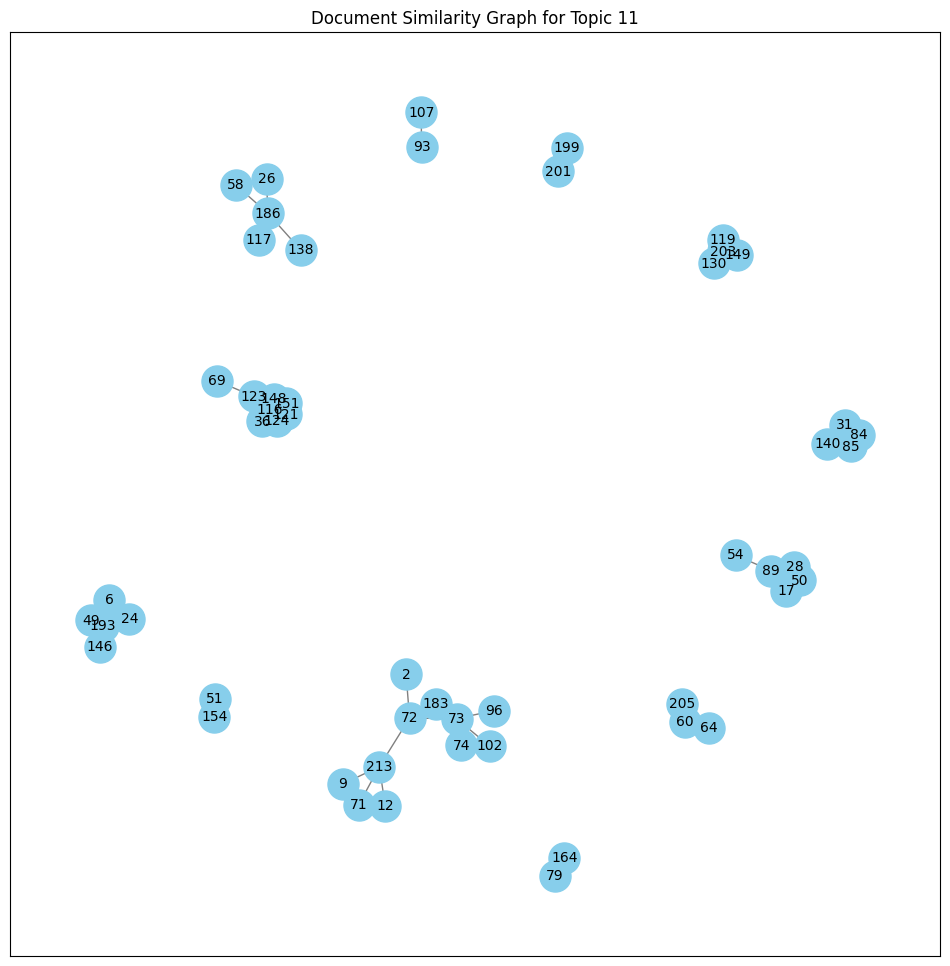

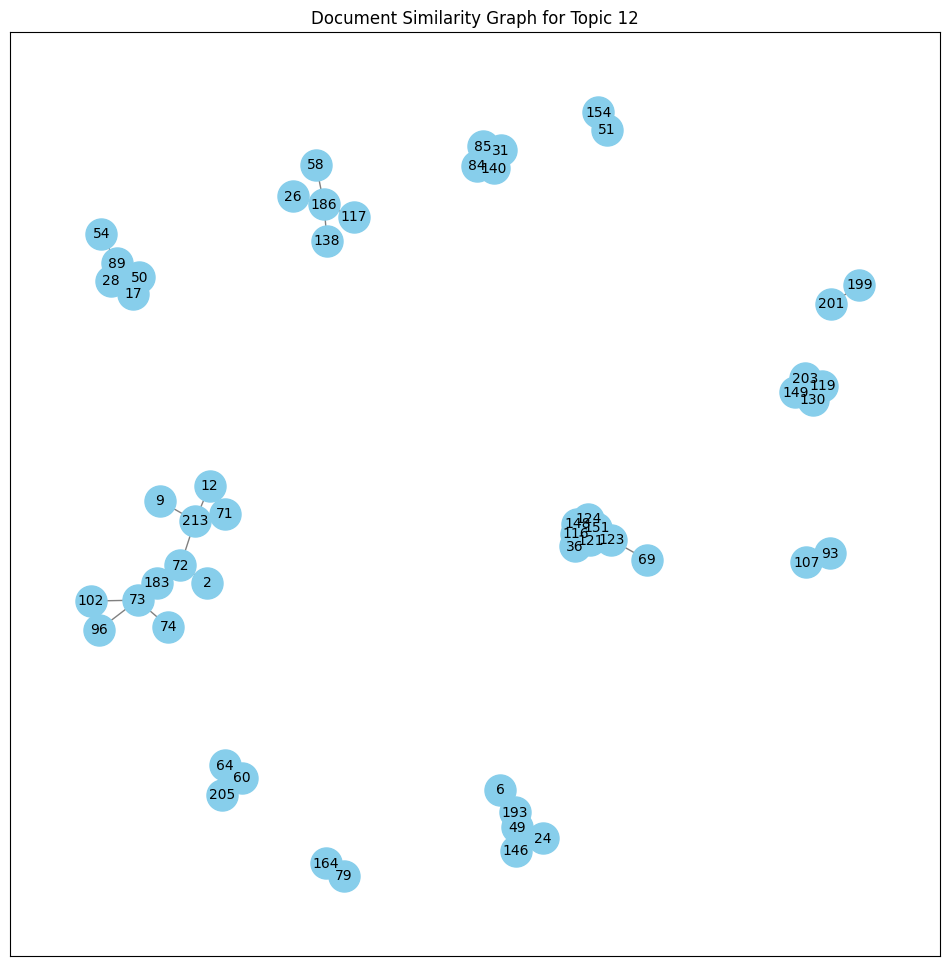

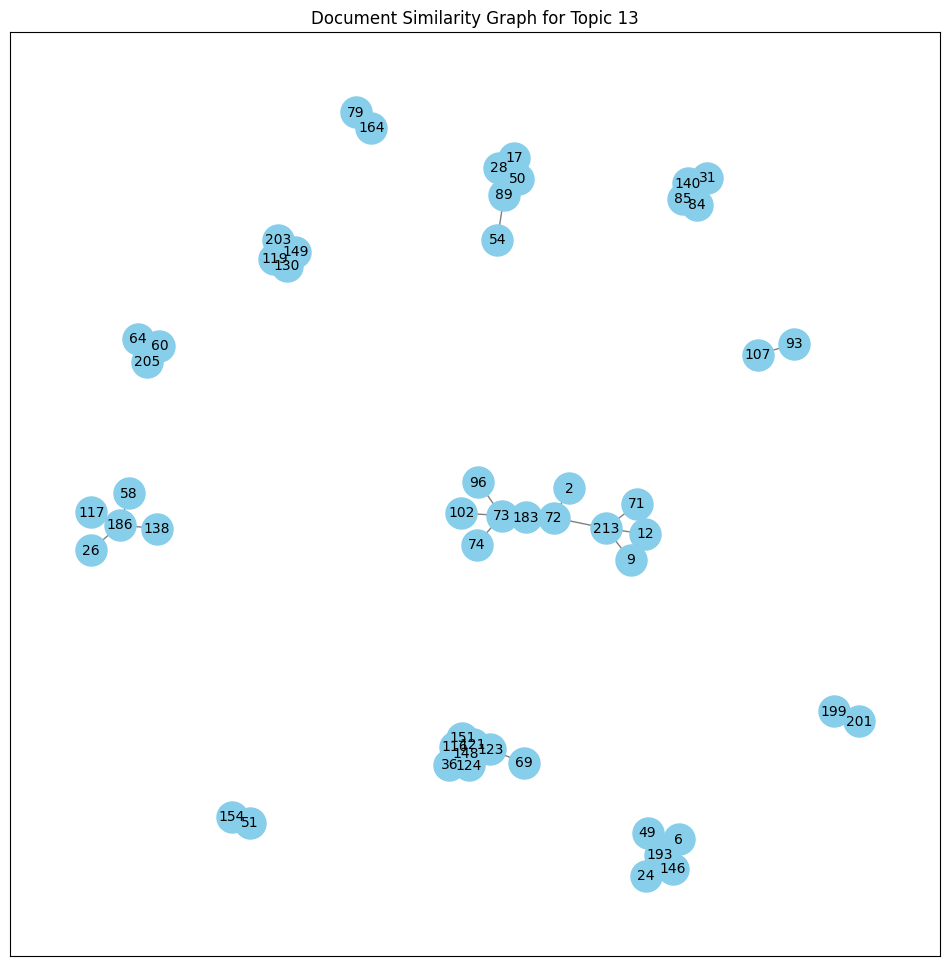

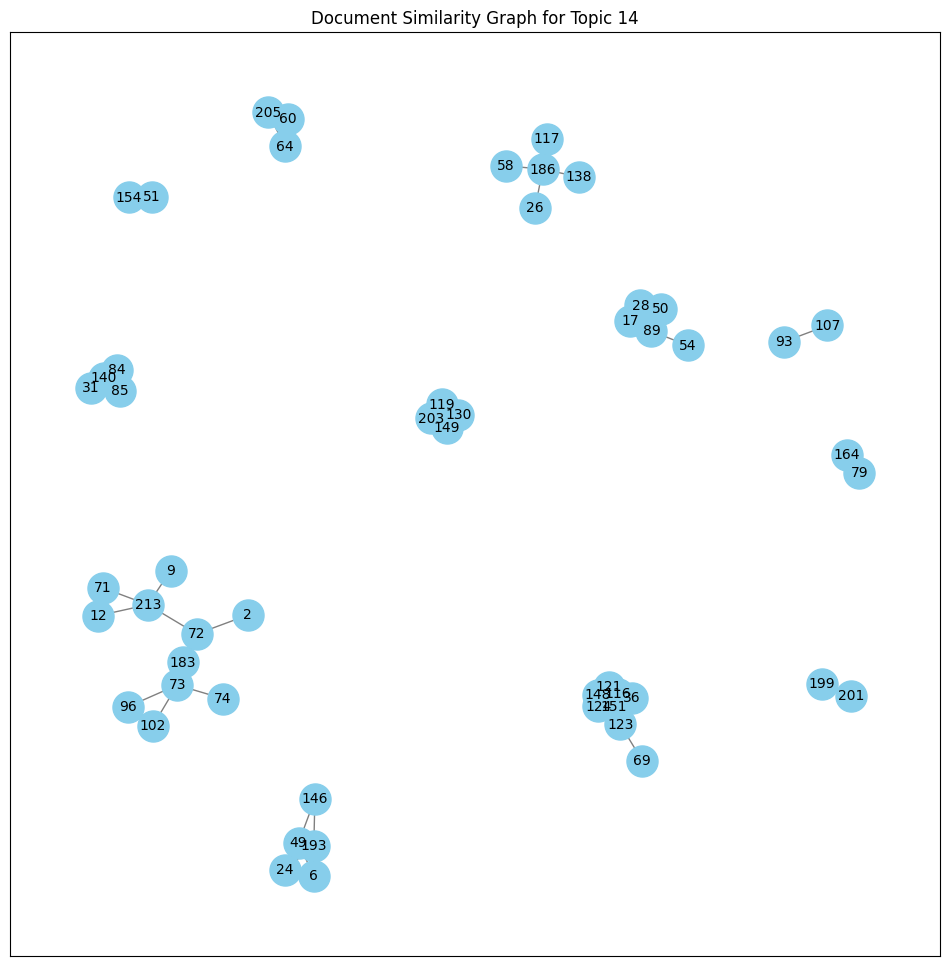

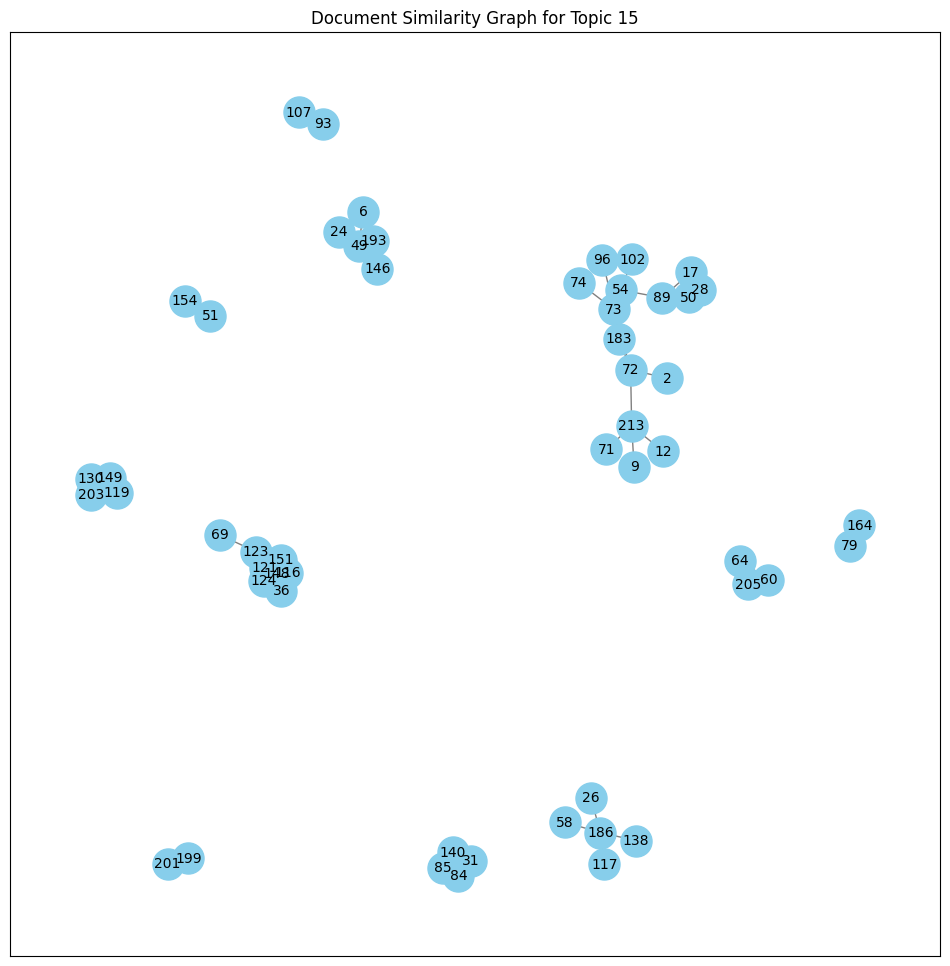

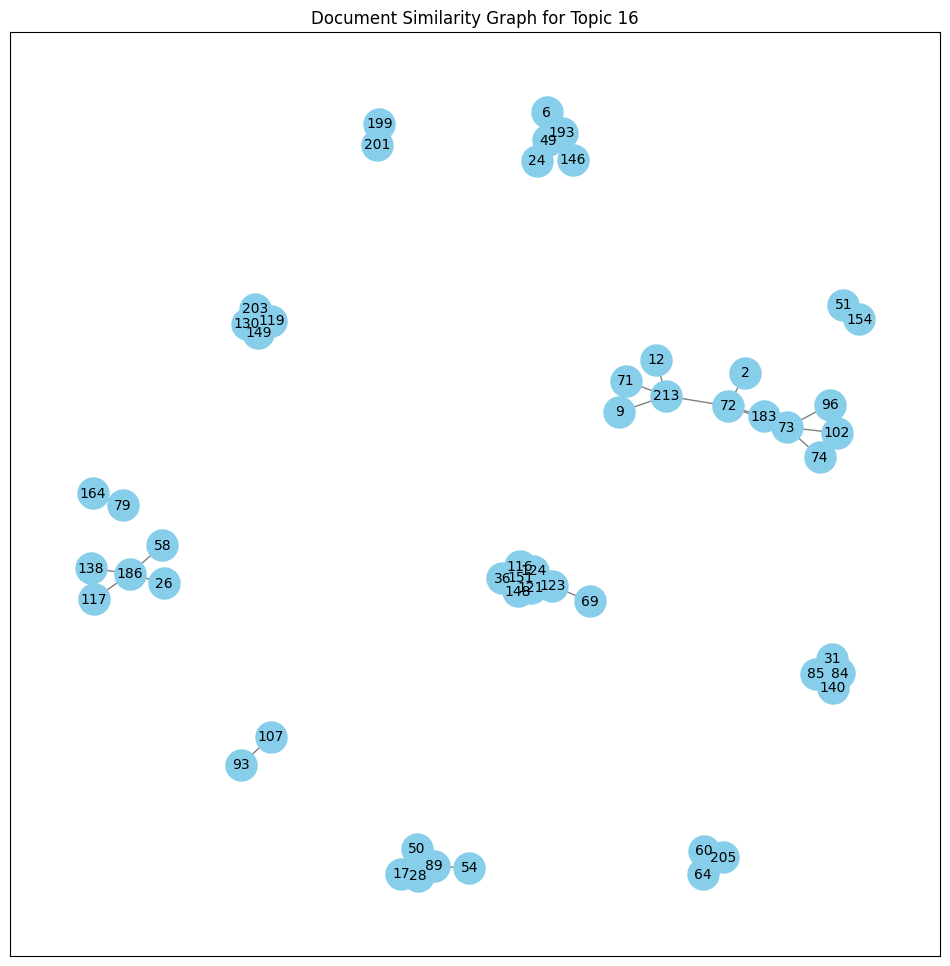

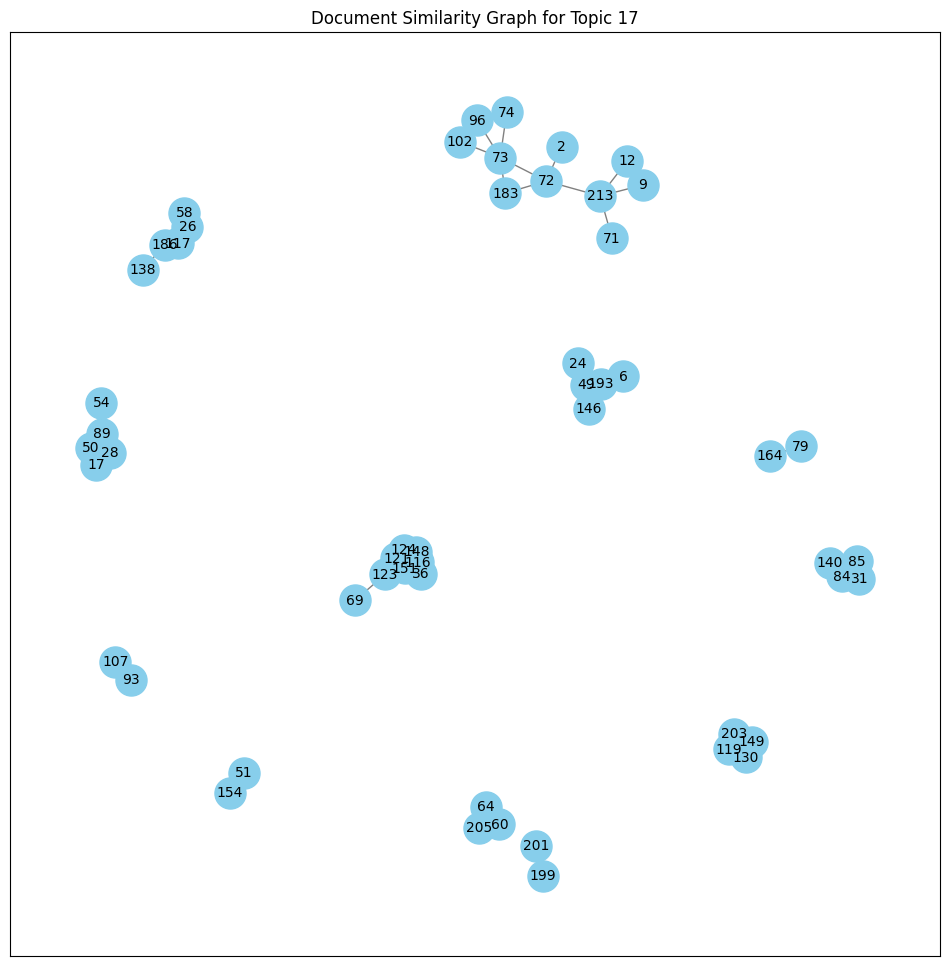

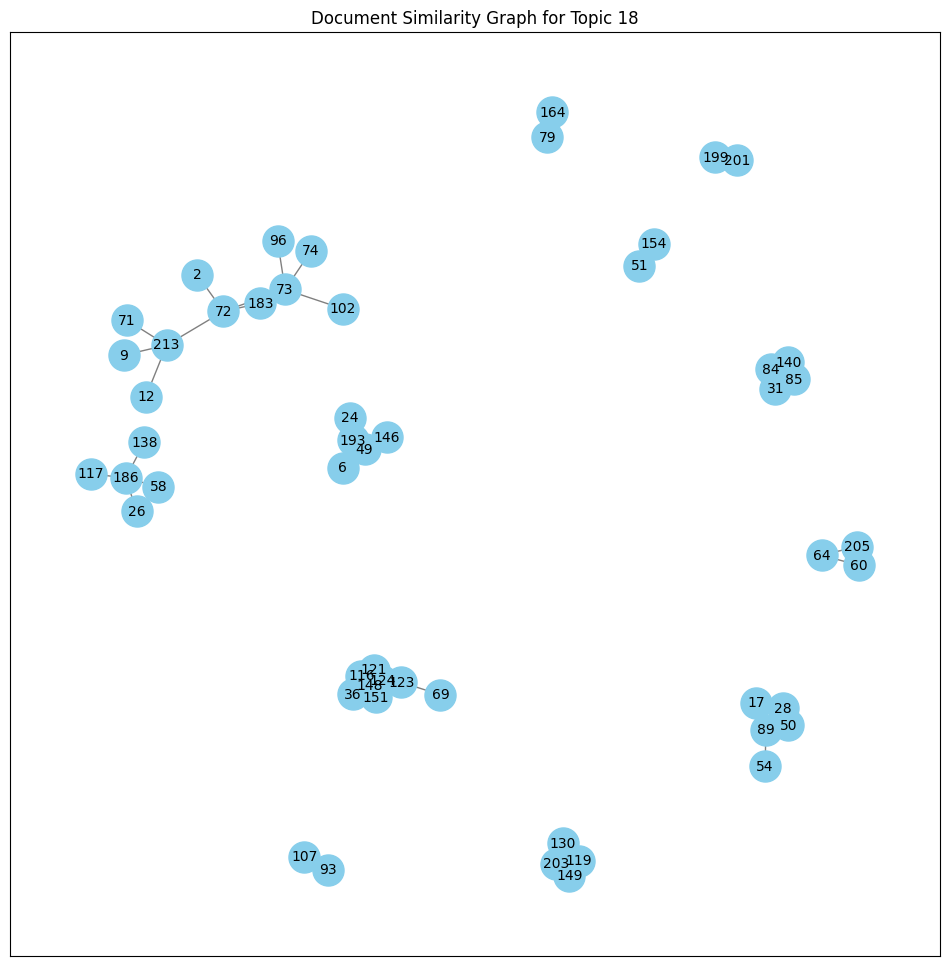

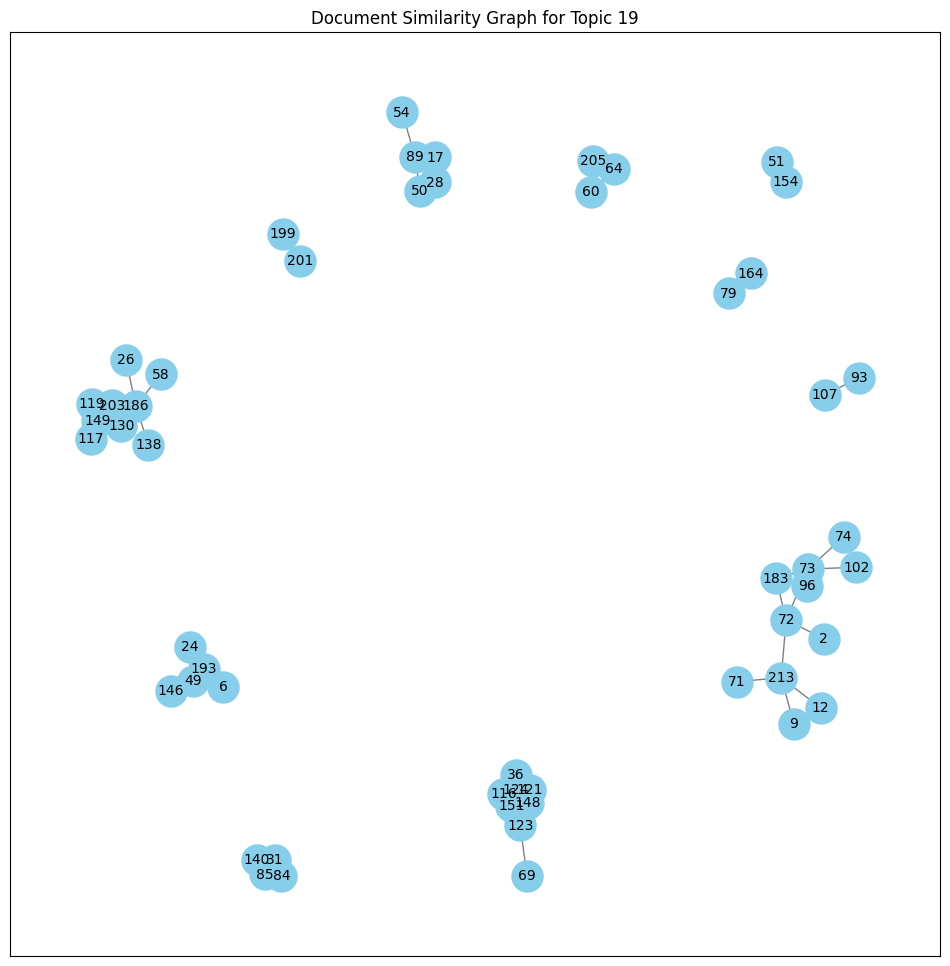

In [65]:
for topic_idx in range(ldaModel.n_components):
    # Extract documents related to the current topic (as before)
    related_docs_indices = np.where(doc_topic_dist[:, topic_idx] > threshold)[0]
    related_docs = [lPosts[i] for i in related_docs_indices]


# Visualize the graph and save it as an image
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
    plt.title(f"Document Similarity Graph for Topic {topic_idx}")
    plt.savefig(f"reddit_document_similarity_graph_topic_{topic_idx}.png")  # Save the graph as an image
    plt.show()

## Combine Topics for Community Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Communities for Combined Topics 

Community 1:
Document 8: Didn't he cheat on her?
Document 15: Didn’t he cheat on her though
Document 16: Didn’t he cheat on her
Community 2:
Document 18: Is that Kendall Jenner? I didn’t recognise her without her ponytail facelift
Document 20: I didn’t recognize Kendall Jenner.
Community 3:
Document 23: My cats would love her outfit so much.
Document 25: Love Karishma’a outfit!
Community 4:
Document 45: not a half volley
Document 47: Is that what technically counts as a half volley? I always thought half volleys were very soon after the bounce.
Document 48: Not a volley, full nor half.
Document 50: Agree. I'm not comparing half volley to volley.
Community 5:
Document 83: Wow wow wow
Document 84: Wow wow wow
Community 6:
Document 99: Hey, get in line.
Document 109: Hey Ram hey bhagwan hey param pita parmeshwar
Community 7:
Document 100: He’d be a good looking bald man as well
Document 106: This was a deliberate joke about a famously good looking man.
Co

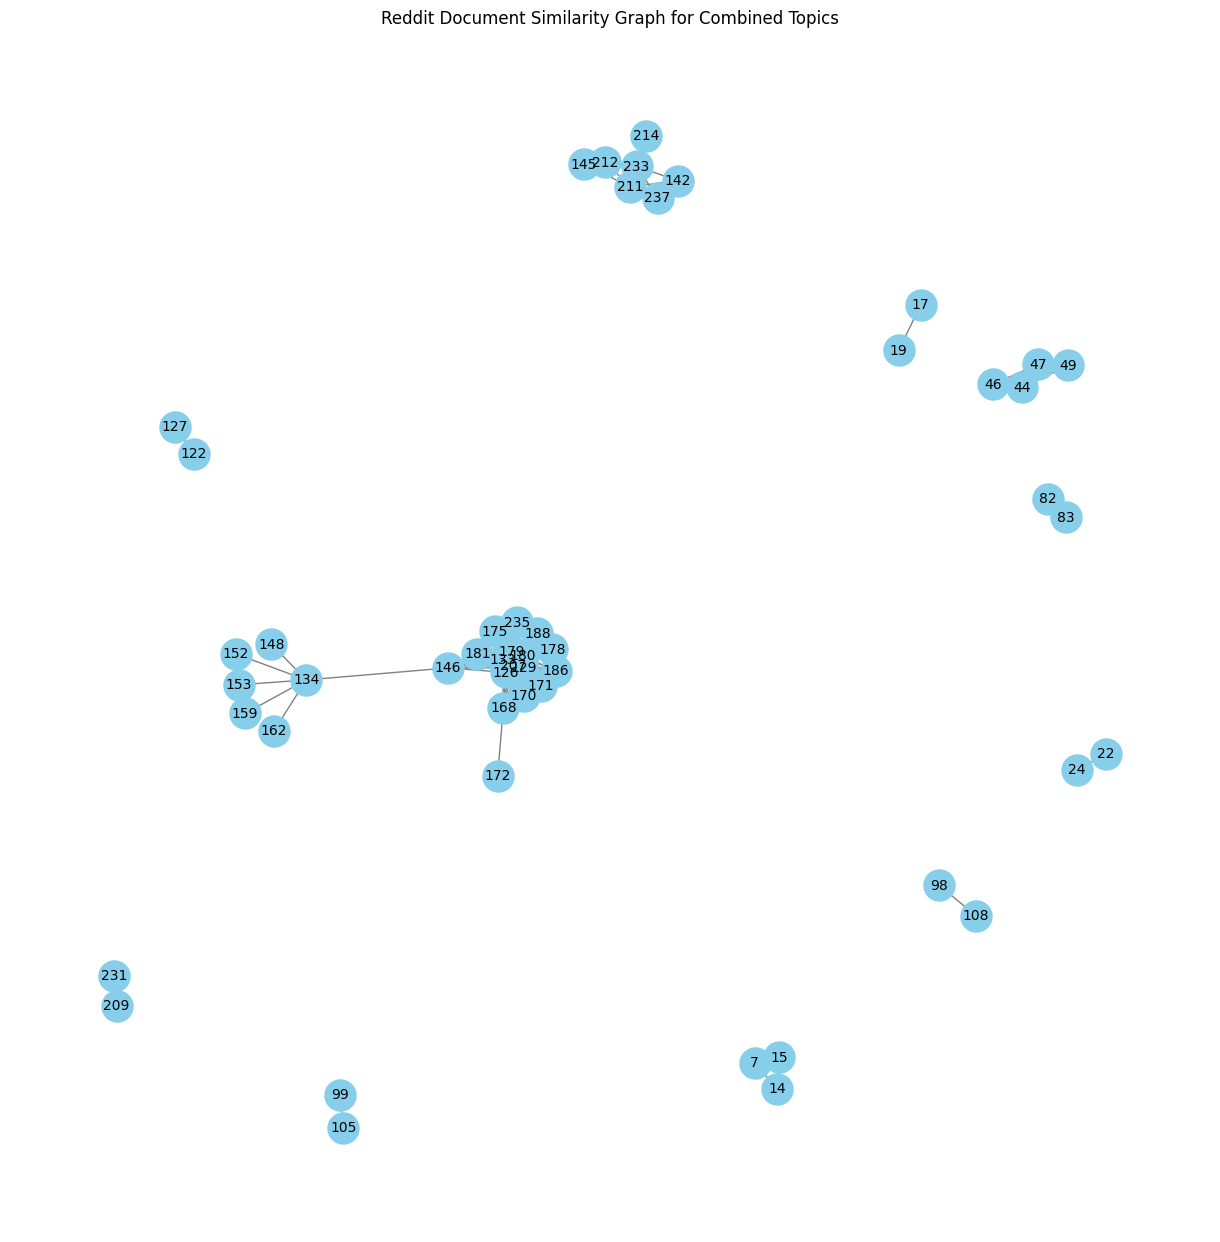

In [66]:
# Define a threshold for considering a document as related to a topic
threshold = 0.6  # Example value, adjust as needed
doc_topic_dist = ldaModel.transform(tf)

# Define the topics of interest
topics_of_interest = [0, 1, 7, 15, 9]

# Extract and combine documents related to the specified topics
combined_docs = []
for topic_idx in topics_of_interest:
    # Extract documents related to the current topic
    related_docs_indices = np.where(doc_topic_dist[:, topic_idx] > threshold)[0]
    related_docs = [lPosts[i] for i in related_docs_indices]
    combined_docs.extend(related_docs)

# # Print the combined documents
# print("Combined Documents from Topics 10, 7, and 17:\n")
# for idx, doc in enumerate(combined_docs):
#     print(f"Document {idx + 1}: {doc}\n")

# Perform community analysis on the combined documents
# Step 1: Vectorize the combined documents using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(combined_docs)

# Step 2: Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Step 3: Create a graph from the cosine similarity matrix
G = nx.Graph()
for i in range(len(combined_docs)):
    for j in range(i + 1, len(combined_docs)):
        if cosine_sim_matrix[i, j] > 0.5:
            G.add_edge(i, j, weight=cosine_sim_matrix[i, j])

# Step 4: Detect communities using the Girvan-Newman method
communities_generator = community.girvan_newman(G)  # Call girvan_newman directly from the community module
top_level_communities = next(communities_generator)
sorted_communities = sorted(map(sorted, top_level_communities))

# communities_to_remove = [0,1,2,4,5,6,7,8,9,10,11]
# sorted_communities = [community for idx, community in enumerate(sorted_communities) if idx not in communities_to_remove]
# Print the communities
print("Communities for Combined Topics \n")
for idx, community_list in enumerate(sorted_communities):
    print(f"Community {idx + 1}:")
    for doc_idx in community_list:
        print(f"Document {doc_idx + 1}: {combined_docs[doc_idx]}")
    print("="*80)  # Separator between communities

# Export the graph to a GEXF file for Gephi
nx.write_gexf(G, "reddit_combined_document_similarity_graph.gexf")

# Visualize the graph and save it as an image
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
plt.title("Reddit Document Similarity Graph for Combined Topics")
plt.savefig("reddit_combined_document_similarity_graph.png")  # Save the graph as an image
plt.show()